<font size="5"><b>Class to load data</b></font>

In [100]:
import json
class load_data:
    def __init__(self):
        pass
   
    '''
    function to iterate over list to form dict of examples with user defined number of classes (So that we do not repeat lines of code for train, val and test)
    input: json file, number of classes data to extract
    output: dictoinary with key as class and value as list of training examples
    '''

    def iterate_over_data(self, data_list, num_classes):
        data_list_num_classes_dict={}
        for training_example in data_list:
            if training_example[1] in data_list_num_classes_dict:
                temp_val=data_list_num_classes_dict[training_example[1]]
                temp_val.append(training_example[0])
            elif len(data_list_num_classes_dict) == num_classes:
                break
            else:
                data_list_num_classes_dict[training_example[1]]=[training_example[0]]

        return data_list_num_classes_dict
    
    '''
    function to load the data
    input: json file, number of classes data to extract
    output: dictionaries with key as class and value as list of examples
    '''
    def load_data_all_sets(self, file, num_classes):
        with open(file) as f:
            data_full = json.load(f)

        data_for_num_classes=self.iterate_over_data(data_full['train'], num_classes)
        data_for_num_classes_val=self.iterate_over_data(data_full['val'], num_classes)
        data_for_num_classes_test=self.iterate_over_data(data_full['test'], num_classes)

        print("---------train------------")
        for key,value in data_for_num_classes.items():
            print(key, len(value))

        print("---------val------------")
        for key,value in data_for_num_classes_val.items():
            print(key, len(value))

        print("---------test------------")
        for key,value in data_for_num_classes_test.items():
            print(key, len(value))

        return data_for_num_classes, data_for_num_classes_val, data_for_num_classes_test


In [101]:
load_data_obj=load_data()
data_for_20_classes, data_for_20_classes_val, data_for_20_classes_test=load_data_obj.load_data_all_sets('/home/aindani/loyal/oos-eval-master/data/data_full.json', 20)

---------train------------
translate 100
transfer 100
timer 100
definition 100
meaning_of_life 100
insurance_change 100
find_phone 100
travel_alert 100
pto_request 100
improve_credit_score 100
fun_fact 100
change_language 100
payday 100
replacement_card_duration 100
time 100
application_status 100
flight_status 100
flip_coin 100
change_user_name 100
where_are_you_from 100
---------val------------
translate 20
transfer 20
timer 20
definition 20
meaning_of_life 20
insurance_change 20
find_phone 20
travel_alert 20
pto_request 20
improve_credit_score 20
fun_fact 20
change_language 20
payday 20
replacement_card_duration 20
time 20
application_status 20
flight_status 20
flip_coin 20
change_user_name 20
where_are_you_from 20
---------test------------
translate 30
transfer 30
timer 30
definition 30
meaning_of_life 30
insurance_change 30
find_phone 30
travel_alert 30
pto_request 30
improve_credit_score 30
fun_fact 30
change_language 30
payday 30
replacement_card_duration 30
time 30
application_

<font size="5"><b>Class to preprocess data</b></font>

In [102]:
import spacy
import unidecode
from word2number import w2n
from pycontractions import Contractions
import gensim.downloader as api

class data_preprocessing:
    
    def __init__(self, contraction_model="glove-twitter-25", spacy_model='en', deselect_words=['no', 'not']):
        self.nlp = spacy.load(spacy_model)
        # Choose model accordingly for contractions function
        self.model = api.load(contraction_model)
        # model = api.load("glove-twitter-100")
        # model = api.load("word2vec-google-news-300")

        self.cont = Contractions(kv_model=self.model)
        self.cont.load_models()

        # exclude words from spacy stopwords list
        self.deselect_stop_words = deselect_words
        for w in self.deselect_stop_words:
            self.nlp.vocab[w].is_stop = False
    
    def remove_whitespace(self, text):
        """remove extra whitespaces from text"""
        text = text.strip()
        return " ".join(text.split())


    def remove_accented_chars(self, text):
        """remove accented characters from text, e.g. café"""
        text = unidecode.unidecode(text)
        return text


    def expand_contractions(self, text):
        """expand shortened words, e.g. don't to do not"""
        text = list(self.cont.expand_texts([text], precise=True))[0]
        return text


    def text_preprocessing(self, text, accented_chars=True, contractions=True, 
                           convert_num=True, extra_whitespace=True, 
                           lemmatization=True, lowercase=True, punctuations=True, 
                           remove_num=True, special_chars=True, 
                           stop_words=True):
        """preprocess text with default option set to true for all steps"""

        if extra_whitespace == True: #remove extra whitespaces
            text = self.remove_whitespace(text)
        if accented_chars == True: #remove accented characters
            text = self.remove_accented_chars(text)
        if contractions == True: #expand contractions
            text = self.expand_contractions(text)
        if lowercase == True: #convert all characters to lowercase
            text = text.lower()

        doc = self.nlp(text) #tokenise text

        clean_text = []

        for token in doc:
            flag = True
            edit = token.text
            # remove stop words
            if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
                flag = False
            # remove punctuations
            if punctuations == True and token.pos_ == 'PUNCT' and flag == True: 
                flag = False
            # remove special characters
            if special_chars == True and token.pos_ == 'SYM' and flag == True: 
                flag = False
            # remove numbers
            if remove_num == True and (token.pos_ == 'NUM' or token.text.isnumeric()) \
            and flag == True:
                flag = False
            # convert number words to numeric numbers
            if convert_num == True and token.pos_ == 'NUM' and flag == True:
                edit = w2n.word_to_num(token.text)
            # convert tokens to base form
            elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
                edit = token.lemma_
            # append tokens edited and not removed to list 
            if edit != "" and flag == True:
                clean_text.append(edit)        
        return clean_text
    
    def run_data_preprocessing(self,data_for_20_classes_dict):
        training_examples=[]
        classes=[]
        classes_category_to_id={}
        for cur_index, (key, value) in enumerate(data_for_20_classes_dict.items()):
            classes_category_to_id[key]=cur_index
            for item in value:
                training_examples.append(self.text_preprocessing(item))
                classes.append(cur_index)

        return training_examples, classes, classes_category_to_id
    

In [103]:
data_preprocessing_obj=data_preprocessing()
clean_text=data_preprocessing_obj.text_preprocessing("transfer $20000 from my savings account to checking account")
print(clean_text)
training_examples, classes, classes_category_to_id = data_preprocessing_obj.run_data_preprocessing(data_for_20_classes)
val_examples, classes_val, classes_category_to_id_val = data_preprocessing_obj.run_data_preprocessing(data_for_20_classes_val)
test_examples, classes_test, classes_category_to_id_test = data_preprocessing_obj.run_data_preprocessing(data_for_20_classes_test)

INFO - 20:28:34: loading projection weights from /home/aindani/gensim-data/glove-twitter-25/glove-twitter-25.gz
INFO - 20:29:07: loaded (1193514, 25) matrix from /home/aindani/gensim-data/glove-twitter-25/glove-twitter-25.gz


['transfer', 'saving', 'account', 'check', 'account']


INFO - 20:29:07: Removed 1 and 0 OOV words from document 1 and 2 (respectively).
INFO - 20:29:07: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 20:29:07: built Dictionary(8 unique tokens: ['for', 'goodbye', 'hawaii', 'in', 'local']...) from 2 documents (total 14 corpus positions)
INFO - 20:29:07: Removed 1 and 0 OOV words from document 1 and 2 (respectively).
INFO - 20:29:07: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 20:29:07: built Dictionary(8 unique tokens: ['for', 'goodbye', 'hawaii', 'in', 'local']...) from 2 documents (total 14 corpus positions)
INFO - 20:29:07: Removed 1 and 0 OOV words from document 1 and 2 (respectively).
INFO - 20:29:07: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 20:29:07: built Dictionary(9 unique tokens: ['do', 'german', 'how', 'in', 'say']...) from 2 documents (total 16 corpus positions)
INFO - 20:29:07: Removed 1 and 0 OOV words from document 1 and 2 (respectively).
INFO - 20:29:07: adding document #0 to

<font size="5"><b>Class with ML classifiers and evaluations metrics</b></font>

In [104]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

class evaluate_models:
    def __init__(self):
        pass
    
    def run_ml_models(self,X_train_features,X_test_features,y_train,y_test):
        logistic_model = LogisticRegression(n_jobs=1, C=1e5, max_iter=200)
        forest_model = RandomForestClassifier()
        linear_svm_model = SVC(kernel='linear')
        svm_model = SVC()
        knn_model = KNeighborsClassifier(n_neighbors=3)

        models = {"logistic_model":logistic_model,
                  "forest_model":forest_model
                  , "linear_svm_model":linear_svm_model,
                  "svm_model":svm_model,
                  "knn_model":knn_model}

        for model_name, model in models.items():
            print(model_name)
            reg = model
            reg = reg.fit(X_train_features, y_train)
            y_pred = reg.predict(X_test_features)
            print('accuracy %s' % accuracy_score(y_pred, y_test))
            print(classification_report(y_test, y_pred))


<font size="5"><b>Class for TFIDF experiment</b></font>

In [105]:
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix

class tfidf_model:
    def __init__(self, training_examples, classes, val_examples, classes_val, test_examples, classes_test, classes_category_to_id):
        self.data_for_tfidf=[]
        self.data_for_tfidf_val=[]
        self.data_for_tfidf_test=[]
        self.classes=classes
        self.classes_val=classes_val
        self.classes_test=classes_test
        self.classes_category_to_id=classes_category_to_id
        
        for line in training_examples:
            str1 = " "
            self.data_for_tfidf.append(str1.join(line))
        for line in val_examples:
            str1 = " "
            self.data_for_tfidf_val.append(str1.join(line))
        for line in test_examples:
            str1 = " "
            self.data_for_tfidf_test.append(str1.join(line))
        
        self.tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
        self.training_features = self.tfidf.fit_transform(self.data_for_tfidf).toarray()
        
        self.evaluate_models_obj=evaluate_models()

        
    def chi2_check_max_correlation(self, classes_category_to_id, N = 2):      
        for Product, category_id in sorted(classes_category_to_id.items()):
            features_chi2 = chi2(features, labels == category_id)
            indices = np.argsort(features_chi2[0])
            feature_names = np.array(tfidf.get_feature_names())[indices]
            unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
            bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
            print("# '{}':".format(Product))
            print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
            print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    
    def cross_validation(self, CV = 10):
        #adding validation data as well to do cross validation
        tfidf_val = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
        features = tfidf_val.fit_transform(self.data_for_tfidf + self.data_for_tfidf_val).toarray()
        labels = np.array(self.classes + self.classes_val)

        models = [
            RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
            LinearSVC(),
            MultinomialNB(),
            LogisticRegression(random_state=0),
        ]    
        cv_df = pd.DataFrame(index=range(CV * len(models)))
        entries = []

        for model in models:
            model_name = model.__class__.__name__
            accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
            for fold_idx, accuracy in enumerate(accuracies):
                entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


        
        sns.boxplot(x='model_name', y='accuracy', data=cv_df)
        sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                      size=10, jitter=True, edgecolor="gray", linewidth=2)
        plt.show()
    
    def train_model(self, model = LinearSVC()):
        labels = np.array(self.classes)
        X_train = self.training_features
        y_train = np.reshape(labels,(labels.shape[0],1))
        model.fit(X_train, y_train)
        
        return model
    
    def plot_confusion(self,y_test, y_pred):
        conf_mat = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(conf_mat, annot=True, fmt='d',
                    xticklabels=classes_category_to_id.keys(), yticklabels=classes_category_to_id.keys())
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
      
    def evaluate_model_different_ML_classifiers(self,model):     
        features_test = self.tfidf.transform(self.data_for_tfidf_test).toarray()    
        labels_test = np.array(self.classes_test)
        
        X_test = features_test
        y_test = np.reshape(labels_test,(labels_test.shape[0],1))
        y_pred = model.predict(X_test)
        
        print("---------------Cross-validation with different classifiers -----------------")
        self.cross_validation()
        
        print("---------------Plotting confusion matrix for best model as per CV-----------------")
        self.plot_confusion(y_test, y_pred)
        
        print("---------------Printing classification report -----------------")
        self.evaluate_models_obj.run_ml_models(self.training_features,features_test,self.classes,self.classes_test)
        
        #print(metrics.classification_report(y_test,y_pred, target_names=self.classes_category_to_id.keys()))
        
        
    

/home/aindani/.conda/envs/loyal/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


---------------Cross-validation with different classifiers -----------------


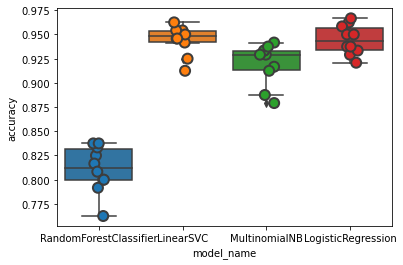

---------------Plotting confusion matrix for best model as per CV-----------------


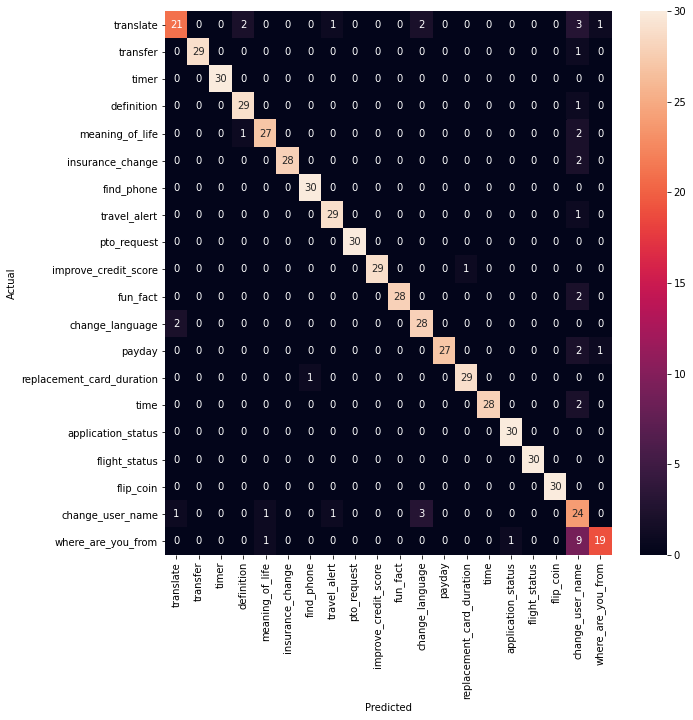

---------------Printing classification report -----------------
logistic_model


/home/aindani/.conda/envs/loyal/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.925
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        30
           1       0.97      0.97      0.97        30
           2       1.00      1.00      1.00        30
           3       0.90      0.93      0.92        30
           4       0.93      0.90      0.92        30
           5       1.00      0.93      0.97        30
           6       0.97      1.00      0.98        30
           7       1.00      0.97      0.98        30
           8       1.00      1.00      1.00        30
           9       1.00      1.00      1.00        30
          10       1.00      0.93      0.97        30
          11       0.90      0.90      0.90        30
          12       1.00      0.93      0.97        30
          13       1.00      0.87      0.93        30
          14       1.00      0.93      0.97        30
          15       0.88      1.00      0.94        30
          16       1.00      1.00      1.00        30
          17

In [106]:
tfidf_model_obj=tfidf_model(training_examples, classes, val_examples, classes_val, test_examples, classes_test, classes_category_to_id)
trained_model=tfidf_model_obj.train_model()
tfidf_model_obj.evaluate_model_different_ML_classifiers(trained_model)

<font size="5"><b>Class for Word2vec experiment</b></font>

In [109]:
from gensim.models import Word2Vec
import gensim
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

class word2vec:
    def __init__(self, X_train_tokenized, X_test_tokenized, y_train, y_test, model_path):
        self.wv = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)
        self.wv.init_sims(replace=True)
        self.X_train_tokenized=X_train_tokenized
        self.X_test_tokenized=X_test_tokenized
        self.y_train=y_train
        self.y_test=y_test
        
        self.evaluate_models_obj=evaluate_models()
    
    #In Bag of words we can do the word averaging of the sentence as its the most common way
    def word_averaging(self, words):
        all_words, mean = set(), []
        #print(words)
        for word in words:
            if isinstance(word, np.ndarray):
                mean.append(word)
            elif word in self.wv.vocab:
                mean.append(self.wv.syn0norm[self.wv.vocab[word].index])
                all_words.add(self.wv.vocab[word].index)

        if not mean:
            logging.warning("cannot compute similarity with no input %s", words)
            # FIXME: remove these examples in pre-processing
            return np.zeros(self.wv.vector_size,)

        mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
        return mean

    def word_averaging_list(self, text_list):
        return np.vstack([self.word_averaging(post) for post in text_list])
    
    #Taking means of the word vectors
    def take_word_vector_means(self):
        X_train_word_average = self.word_averaging_list(self.X_train_tokenized)
        X_test_word_average = self.word_averaging_list(self.X_test_tokenized)
        return X_train_word_average,X_test_word_average

    def run_ml_models_and_evaluate(self,X_train_word_average,X_test_word_average):
        self.evaluate_models_obj.run_ml_models(X_train_word_average,X_test_word_average,self.y_train,self.y_test)
        

In [110]:
word2vec_obj=word2vec(training_examples, test_examples, classes, classes_test, "/home/aindani/loyal/GoogleNews-vectors-negative300.bin.gz")
X_train_word_average,X_test_word_average=word2vec_obj.take_word_vector_means()
word2vec_obj.run_ml_models_and_evaluate(X_train_word_average,X_test_word_average)

INFO - 20:32:23: loading projection weights from /home/aindani/loyal/GoogleNews-vectors-negative300.bin.gz
INFO - 20:34:17: loaded (3000000, 300) matrix from /home/aindani/loyal/GoogleNews-vectors-negative300.bin.gz
INFO - 20:34:17: precomputing L2-norms of word weight vectors
/home/aindani/.conda/envs/loyal/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
WARNING - 20:34:20: cannot compute similarity with no input ['ataraxy']
WARNING - 20:34:20: cannot compute similarity with no input []
WARNING - 20:34:20: cannot compute similarity with no input ['ishmael']
WARNING - 20:34:20: cannot compute similarity with no input []
WARNING - 20:34:20: cannot compute similarity with no input []
WARNING - 20:34:20: cannot compute similarity with no input []
WARNING - 20:34:20: cannot compute similarity with no input []
WARNING - 20:34:20: cannot compute similarity with no inpu

logistic_model


/home/aindani/.conda/envs/loyal/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.96
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        30
           1       0.97      0.97      0.97        30
           2       1.00      1.00      1.00        30
           3       0.97      1.00      0.98        30
           4       0.97      0.97      0.97        30
           5       0.97      0.97      0.97        30
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        30
           8       0.97      0.93      0.95        30
           9       1.00      1.00      1.00        30
          10       0.97      0.97      0.97        30
          11       0.88      0.93      0.90        30
          12       1.00      0.97      0.98        30
          13       0.96      0.90      0.93        30
          14       1.00      0.97      0.98        30
          15       0.88      0.97      0.92        30
          16       1.00      1.00      1.00        30
          17 